### Libraries

In [2]:
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.metrics          import accuracy_score, confusion_matrix
from sklearn.naive_bayes      import GaussianNB
from sklearn.preprocessing    import StandardScaler, Normalizer
from sklearn.feature_selection import SequentialFeatureSelector

### 1. Data Profiling

In [3]:
data = pd.read_csv('data/drought.csv')
data = data.rename(columns = {"class" : "drought"})
dtypesCount = data.dtypes
dfDtypesCount = pd.DataFrame(dtypesCount)
sumDtypes = dfDtypesCount.value_counts()
sumDtypes


float64    40
int64      11
object      1
dtype: int64

In [ ]:
data['day'] = pd.DatetimeIndex(data['date'], dayfirst=True).day
data['month'] = pd.DatetimeIndex(data['date'], dayfirst=True).month
data['year'] = pd.DatetimeIndex(data['date'], dayfirst=True).year
data = data[[col for col in data if col not in ['drought']] + ['drought']]
data.pop('date')
data

In [135]:
dtypesCount = data.dtypes
dfDtypesCount = pd.DataFrame(dtypesCount)
sumDtypes = dfDtypesCount.value_counts()
sumDtypes

float64    40
int64      14
dtype: int64

#### 1.1. Data Dimensionality

In [4]:
dataDim = pd.DataFrame(data=[[len(data), len(data.columns)], [7671, 7], [101766, 50], [596, 2]], columns=['Nr Records', 'Nr Variables'], index=['Drought_classification', 'Drought_forecasting', 'Diabetic_classification', 'Diabetic_forecasting'])
dataDim

,Nr Records,Nr Variables
Drought_classification,59429,52
Drought_forecasting,7671,7
Diabetic_classification,101766,50
Diabetic_forecasting,596,2


In [6]:
dataDataTypes = pd.DataFrame(data=[[11, 40, 1], [0, 7, 0], [13, 0, 37], [0, 2, 0]], columns=['Int64', 'Float64', 'Object', ], index=['Drought_classification', 'Drought_forecasting', 'Diabetic_classification', 'Diabetic_forecasting'])
dataDataTypes

,Int64,Float64,Object
Drought_classification,11,40,1
Drought_forecasting,0,7,0
Diabetic_classification,13,0,37
Diabetic_forecasting,0,2,0


#### 1.2. Data Distribution

##### 1.2.1. Histograms

In [139]:
def histograms(data, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(50, 80))
    
    for position in range(len(data.columns)):
        col = data.columns[position]

        pos_i = position//j
        pos_j = position%j
        

        dist_0 = data[data['drought']==0][col]
        dist_1 = data[data['drought']==1][col]

        ax[pos_i][pos_j].hist([dist_0, dist_1],
                          stacked=False,
                          label=['drought = 0', 'drought = 1'],
                          color=['#7547B8', '#8AB847'])
        ax[pos_i][pos_j].set_title(col)
        ax[pos_i][pos_j].legend()

    plt.savefig('plots/drought_hist01.png')


In [ ]:
histograms(data, (9, 6))

##### 1.2.2. Boxplots

In [142]:
def boxplotAllInd(data, filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(50, 80))
    
    for position in range(len(data.columns)):
        col = data.columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].boxplot(data[col])
        ax[pos_i][pos_j].set_title(col)

    plt.savefig('plots/' + filename + '.png')
    plt.close()

In [143]:
boxplotAllInd(data, 'boxplot_drought_classification_allInd', (9, 6))

TypeError: 'AxesSubplot' object is not subscriptable

In [ ]:
def boxplot(data, filename):
    """"""

    sns.set(rc={"figure.figsize":(16, 14)})
    sns.boxplot(data=data)
    plt.xticks(rotation='vertical')
    plt.savefig('plots/'+filename + ".png")
    plt.close()

In [ ]:
boxplot(data, 'boxplot_drought_classification_all')

In [ ]:
# Groups of attributes to plot together: 
# fips and year
# Interval of values: [0,1) - slope1, slope2, slope3, slope4, slope5, slope6, slope7, slope8, aspectN, aspectE, aspectS, aspectW, aspectUnknown
# Interval of values: [1,10) - WS10M,WS10M_MIN, WS50M_MIN, SQ1, SQ2, SQ3, SQ4, SQ5, SQ6, SQ7, drought
# Interval of values: [0,21) - QV2M,WS10M_MAX, WS10M_RANGE, WS50M, WS50M_MAX, month
# Interval of values: [-20, 50) - T2M, T2MDEW, T2MWET, T2M_MAX, T2M_MIN, T2M_var_categoricas = [x for x in dados.columns if dados[x].dtype=='object']
# Interval of values: [0, 102) - WAT_LAND, NVG_LAND, URB_LAND, GRS_LAND, FOR_LAND, CULTRF_LAND, CULTIR_LAND, CULT_LAND, day, PRECTOT

dataValuesPerIntervals = [data[["slope1", "slope2", "slope3", "slope4", "slope5", "slope6", "slope7", 
                                "slope8", "aspectN", "aspectE", "aspectS", "aspectW", "aspectUnknown"]], 
                            data[["WS10M","WS10M_MIN", "WS50M_MIN", "SQ1", "SQ2", "SQ3", "SQ4", "SQ5", 
                            "SQ6", "SQ7", "drought"]], 
                            data[["QV2M","WS10M_MAX", "WS10M_RANGE", "WS50M", "WS50M_MAX", "month"]], 
                            data[["T2M", "T2MDEW", "T2MWET", "T2M_MAX", "T2M_MIN", "T2M_RANGE", "TS"]], 
                            data["lon"], data["lat"], data["elevation"], data[["fips", "year"]],
                            data[["WAT_LAND", "NVG_LAND", "URB_LAND", "GRS_LAND", "FOR_LAND", "CULTRF_LAND", 
                            "CULTIR_LAND", "CULT_LAND", "day", "PRECTOT"]]]

filenameC = 0
for d in dataValuesPerIntervals:
    boxplot(d, "boxplot_drought_classification_" + filenameC)
    filenameC+=1

#### 1.3. Data Granularity


#### 1.4. Sparsity

In [ ]:
def heatmap(data):
    heatmap = data.corr()
    f, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(heatmap,
                cmap=sns.color_palette("RdBu_r", 1000),
                vmin=-1,
                vmax=1,
                square=True)
    
    plt.savefig('plots/drought_heatmap01.png')
    plt.close()

In [ ]:
heatmap(data)

In [ ]:
def scatterplots(data):
    """ Given the data, the function plot the scatter plots """

    figur = sns.pairplot(data, diag_kind='hist')
    fig = figur.fig
    fig.savefig("plots/scatterplotGeneral.png")
    plt.close()

In [ ]:
scatterplots(data)

### 2. Data Preparation

#### 2.1. Data types and summary

In [ ]:
data.head()

In [ ]:
data.describe()

In [131]:
data.dtypes

fips               int64
PRECTOT          float64
PS               float64
QV2M             float64
T2M              float64
T2MDEW           float64
T2MWET           float64
T2M_MAX          float64
T2M_MIN          float64
T2M_RANGE        float64
TS               float64
WS10M            float64
WS10M_MAX        float64
WS10M_MIN        float64
WS10M_RANGE      float64
WS50M            float64
WS50M_MAX        float64
WS50M_MIN        float64
WS50M_RANGE      float64
lat              float64
lon              float64
elevation          int64
slope1           float64
slope2           float64
slope3           float64
slope4           float64
slope5           float64
slope6           float64
slope7           float64
slope8           float64
aspectN          float64
aspectE          float64
aspectS          float64
aspectW          float64
aspectUnknown    float64
WAT_LAND         float64
NVG_LAND           int64
URB_LAND         float64
GRS_LAND         float64
FOR_LAND         float64


In [ ]:
fipsCount = data['fips'].value_counts()

In [133]:
dtypesCount = data.dtypes
dfDtypesCount = pd.DataFrame(dtypesCount)
sumDtypes = dfDtypesCount.value_counts()
sumDtypes

float64    40
int64      14
dtype: int64

In [ ]:
uniqueValues = data['fips'].nunique()

#### 2.2. Missing Values

In [138]:
nullValues = data.isnull().sum()
nullValues

fips             0
PRECTOT          0
PS               0
QV2M             0
T2M              0
T2MDEW           0
T2MWET           0
T2M_MAX          0
T2M_MIN          0
T2M_RANGE        0
TS               0
WS10M            0
WS10M_MAX        0
WS10M_MIN        0
WS10M_RANGE      0
WS50M            0
WS50M_MAX        0
WS50M_MIN        0
WS50M_RANGE      0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5              0
SQ6              0
SQ7              0
day              0
month            0
year        

#### 2.3. Models to evaluate the intermediate steps

In [120]:
def knn(X_train, X_test, Y_train, Y_test):

    # p=2 resultou numa acurácia menor
    model = KNeighborsClassifier(p=1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    return accuracy_score(Y_test, Y_pred), tn, fp, fn, tp, Y_pred

# Naive Bayes
def nb(X_train, X_test, Y_train, Y_test):

    model = GaussianNB()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    return accuracy_score(Y_test, Y_pred), tn, fp, fn, tp, Y_pred


def temporal_data_split(data, target, train_size=0.95):

    lim = round(len(data)*train_size)
    tmp_data_train = data.loc[0:lim]
    tmp_data_test = data.loc[lim:]
    X_train = tmp_data_train.drop(target,axis=1) 
    Y_train = tmp_data_train[target] 
    X_test = tmp_data_test.drop(target,axis=1)
    Y_test = tmp_data_test[target]
    return X_train, X_test, Y_train, Y_test

#### 2.4. Outliers Treatment

In [80]:
# test_outliers() is a method that test a set of parameters using the distance metodology
# parameters 
# - r: is the ratio that defines the neighborhood
# - f: is the data fraction that should be in the neighborhood, 
# - params: list of tuples where the first element is r and the second is f. it's used to select the outliers, and subsequently 
# train and test the data
#  
params = [(298, 0.01), (298, 0.05), (298, 0.1), (298, 0.2), (298, 0.5), 
          (574, 0.01), (574, 0.05), (574, 0.1), (574, 0.2), (574, 0.5),
          (1000, 0.01), (1000, 0.05), (1000, 0.1), (1000, 0.2), (1000, 0.5)]

def test_outliers(data, params):
    """"""

    test_outliers_stats = pd.DataFrame(columns=['r', 'f', 'n_outliers', 
                                                'knn_accuracy', 'knn_tn', 'knn_fp', 'knn_fn', 'knn_tp', 
                                                'nb_accuracy', 'nb_tn', 'nb_fp', 'nb_fn', 'nb_tp'])
    
    outliers = [[[], 0], [[], 0], [[], 0], [[], 0], [[], 0],
                [[], 0], [[], 0], [[], 0], [[], 0], [[], 0],
                [[], 0], [[], 0], [[], 0], [[], 0], [[], 0]]

    lenD = len(data)
    for c in range(len(data)):
        euclidean_matrix = euclidean_distances(data.iloc[[c]], data)
        
        for p in range(len(params)):
            tmp_df = pd.DataFrame(euclidean_matrix)
            tmp_df = tmp_df < params[p][0]
            frac = params[p][1] * lenD
            if tmp_df.values.sum() < frac:
                outliers[p][0].append(c)
                outliers[p][1]+=1

    c = 0
    for c in range(len(outliers)):

        dataOutliers = data.drop(outliers[c][0], axis=0)

        X_train, X_test, Y_train, Y_test = temporal_data_split(dataOutliers, 'drought')
        if len(X_train) != 0 and len(X_test) != 0 and  len(Y_train) != 0 and  len(Y_test) != 0:
            knn_acc, knn_tn, knn_fp, knn_fn, knn_tp = knn(X_train, X_test, Y_train, Y_test)
            nb_acc, nb_tn, nb_fp, nb_fn, nb_tp  = nb(X_train, X_test, Y_train, Y_test)
            test_outliers_stats.loc[c] = [params[c][0], params[c][1], outliers[c][1], knn_acc, knn_tn, knn_fp, knn_fn, knn_tp, nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

    X_train, X_test, Y_train, Y_test = temporal_data_split(data, 'drought')
    knn_acc, knn_tn, knn_fp, knn_fn, knn_tp = knn(X_train, X_test, Y_train, Y_test)
    nb_acc, nb_tn, nb_fp, nb_fn, nb_tp  = nb(X_train, X_test, Y_train, Y_test)
    test_outliers_stats.loc[c+1] = [0, 0, 0, 
                                                    knn_acc, knn_tn, knn_fp, knn_fn, knn_tp,
                                                    nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

    return test_outliers_stats

In [10]:
countOutliers = 0
pos_outliers = []
frac = 0.05*len(data)
for c in range(len(data)):
    euclidean_matrix = euclidean_distances(data.iloc[[c]], data)
    tmp_df = pd.DataFrame(euclidean_matrix)
    tmp_df = tmp_df < 299
    if tmp_df.values.sum() < frac:
        countOutliers+=1
        pos_outliers.append(c)

dataWithoutOutliers = data.drop(pos_outliers, axis=0)

In [38]:
# count media ordenada

sorted_mean = []
for c in range(len(data)):
    euclidean_distance_vector = euclidean_distances(data.iloc[[c]], data)
    sorted_mean.append(np.mean(euclidean_distance_vector))

In [13]:
dataWithoutOutliers.to_csv("intermediate_data/data_without_outliers.csv", encoding='utf-8', index=False, columns=dataWithoutOutliers.columns)
pos_outliers = pd.DataFrame(pos_outliers)
pos_outliers.to_csv("intermediate_data/position_outliers.csv", index=False)

In [51]:
dist_outliers = [sorted_mean[i] for i in pos_outliers]
df = data.drop(pos_outliers, axis=0)
notOut = df.index
dist_notOutliers = [sorted_mean[i] for i in notOut]

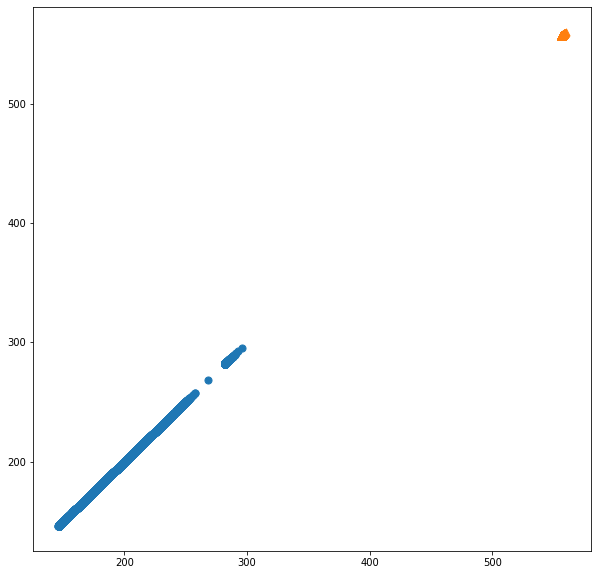

In [69]:
f, ax = plt.subplots(figsize=(10,10))
plt.scatter(dist_notOutliers,dist_notOutliers, s = 50)
plt.scatter(dist_outliers, dist_outliers, marker ="^", s = 50)
plt.savefig('plots/drought_classification_outliersTreatment_distanceMean.png')
plt.show()


#### 2.5. Scaling

In [70]:
dataWithoutOutliers.index = range(0,len(dataWithoutOutliers))
dataWithoutOutliers

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,day,month,year,drought
0,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,2,2,1,1,1,2,4,1,2000,1
1,1001,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,...,2,2,1,1,1,2,11,1,2000,1
2,1001,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,...,2,2,1,1,1,2,18,1,2000,1
3,1001,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,...,2,2,1,1,1,2,25,1,2000,1
4,1001,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,...,2,2,1,1,1,2,1,2,2000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58537,1133,20.79,98.21,10.15,17.33,13.34,13.34,24.64,8.75,15.89,...,1,1,1,1,1,1,29,11,2016,1
58538,1133,14.08,98.40,7.55,10.10,9.33,9.34,13.21,5.49,7.72,...,1,1,1,1,1,1,6,12,2016,1
58539,1133,0.94,99.10,7.63,10.91,9.45,9.45,17.53,4.55,12.98,...,1,1,1,1,1,1,13,12,2016,1
58540,1133,0.08,100.45,3.50,0.37,-1.49,-1.48,7.55,-6.86,14.41,...,1,1,1,1,1,1,20,12,2016,1


In [71]:
test_scaling_stats = pd.DataFrame(columns=['method', 
                                                'knn_accuracy', 'knn_tn', 'knn_fp', 'knn_fn', 'knn_tp', 
                                                'nb_accuracy', 'nb_tn', 'nb_fp', 'nb_fn', 'nb_tp'])

##### 2.5.1. Standardization

In [72]:
std_scaler = StandardScaler()
tmp_dataWithoutOutliers = dataWithoutOutliers.drop('drought', axis=1)
data_std = std_scaler.fit_transform(tmp_dataWithoutOutliers)
data_std = pd.DataFrame(data_std, columns=tmp_dataWithoutOutliers.columns)
data_std['drought'] = dataWithoutOutliers['drought']

In [ ]:
# stats
X_train, X_test, Y_train, Y_test = temporal_data_split(data_std, 'drought')
knn_acc, knn_tn, knn_fp, knn_fn, knn_tp = knn(X_train, X_test, Y_train, Y_test)
nb_acc, nb_tn, nb_fp, nb_fn, nb_tp  = nb(X_train, X_test, Y_train, Y_test)

test_scaling_stats.loc[0] = ['standardization', 
                            knn_acc, knn_tn, knn_fp, knn_fn, knn_tp,
                            nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

In [ ]:
data_std.to_csv("/intermediate_data/data_step_std.csv", encoding='utf-8', index=False, columns=data_std.columns)

##### 2.5.2. Normalization

In [125]:

norm = Normalizer()
tmp_dataWithoutOutliers = dataWithoutOutliers.drop('drought', axis=1)
data_norm = norm.fit_transform(tmp_dataWithoutOutliers)
data_norm = pd.DataFrame(data_norm, columns=tmp_dataWithoutOutliers.columns)
data_norm['drought'] = dataWithoutOutliers['drought']

In [ ]:
# stats
X_train, X_test, Y_train, Y_test = temporal_data_split(data_norm, 'drought')
knn_acc, knn_tn, knn_fp, knn_fn, knn_tp = knn(X_train, X_test, Y_train, Y_test)
nb_acc, nb_tn, nb_fp, nb_fn, nb_tp  = nb(X_train, X_test, Y_train, Y_test)

test_scaling_stats.loc[1] = ['normalization', 
                            knn_acc, knn_tn, knn_fp, knn_fn, knn_tp,
                            nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

##### 2.5.3. No changes

In [121]:
X_train, X_test, Y_train, Y_test = temporal_data_split(dataWithoutOutliers, 'drought')
knn_acc, knn_tn, knn_fp, knn_fn, knn_tp, knn_Y_pred = knn(X_train, X_test, Y_train, Y_test)
nb_acc, nb_tn, nb_fp, nb_fn, nb_tp, nb_Y_pred  = nb(X_train, X_test, Y_train, Y_test)

test_scaling_stats.loc[2] = ['none', 
                            knn_acc, knn_tn, knn_fp, knn_fn, knn_tp,
                            nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

##### 2.5.4. Stats

In [127]:
test_scaling_stats

,method,knn_accuracy,knn_tn,knn_fp,knn_fn,knn_tp,nb_accuracy,nb_tn,nb_fp,nb_fn,nb_tp
0,standardization,0.663820,1071,489,495,872,0.562009,1276,284,998,369
1,normalization,0.618381,1197,363,754,613,0.562692,1307,253,1027,340
2,none,0.655278,1166,394,615,752,0.561326,1273,287,997,370


##### 2.3.5. Results plots

#### 2.6. Feature Selection

In [10]:
knn = KNeighborsClassifier(p=1)

feature_names = np.array(data_std.drop)

X_train, X_test, Y_train, Y_test = temporal_data_split(data_std, 'drought')
X = data_std.drop('drought', axis=1)
y = data_std['drought']

sfs_forward_knn = SequentialFeatureSelector(
    knn, n_features_to_select=50, direction="forward"
).fit(X, y)

sfs_backward_knn = SequentialFeatureSelector(
    knn, n_features_to_select=50, direction="backward"
).fit(X, y)

'sfs_backward_nb = SequentialFeatureSelector(\n    nb, n_features_to_select=50, direction="backward"\n).fit(X, y)'

In [14]:
feature_names = np.array(data_std.drop('drought', axis=1).columns)

In [17]:
# n_features = 50
features_selected_knn_forward = feature_names[sfs_forward_knn.get_support()]
features_selected_knn_backward = feature_names[sfs_backward_knn.get_support()]

data_features_selected_knn_forward = data_std[features_selected_knn_forward]
data_features_selected_knn_backward = data_std[features_selected_knn_backward]

In [19]:
data_features_selected_knn_forward.to_csv("intermediate_data/data_step_fs_knn_forward.csv", encoding='utf-8', index=False, columns=data_features_selected_knn_forward.columns)
data_features_selected_knn_backward.to_csv("intermediate_data/data_step_fs_knn_backward.csv", encoding='utf-8', index=False, columns=data_features_selected_knn_backward.columns)

In [28]:
features_selection_scaling_stats = pd.DataFrame(columns=['estimator', 'direction',
                                                'knn_accuracy', 'knn_tn', 'knn_fp', 'knn_fn', 'knn_tp', 
                                                'nb_accuracy', 'nb_tn', 'nb_fp', 'nb_fn', 'nb_tp'])

In [24]:
tmp_data_features_selected_knn_forward = data_features_selected_knn_forward
tmp_data_features_selected_knn_forward['drought'] = data_std['drought']
tmp_data_features_selected_knn_forward

/tmp/ipykernel_123745/3132865452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data_features_selected_knn_forward['drought'] = data_std['drought']


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,CULT_LAND,SQ3,SQ4,SQ5,SQ6,SQ7,day,month,year,drought
0,1.503945,0.306910,-0.834366,-0.704859,-0.798998,-0.801387,-0.631643,-1.119537,1.207104,-0.700074,...,0.301824,2.025951,-0.435494,0.124035,0.124035,2.025951,-1.328575,-1.601626,-1.633185,1
1,-0.312745,0.416581,-0.789326,-0.695555,-0.584569,-0.587589,-0.542276,-0.709525,0.399816,-0.801651,...,0.301824,2.025951,-0.435494,0.124035,0.124035,2.025951,-0.533019,-1.601626,-1.633185,1
2,-0.340082,0.406611,-0.167336,-0.369933,0.079547,0.078378,-0.637299,-0.334064,-0.799417,-0.367640,...,0.301824,2.025951,-0.435494,0.124035,0.124035,2.025951,0.262537,-1.601626,-1.633185,1
3,-0.478011,0.127447,-1.771640,-2.121315,-2.516878,-2.499479,-2.038889,-1.997146,-0.199801,-2.075984,...,0.301824,2.025951,-0.435494,0.124035,0.124035,2.025951,1.058093,-1.601626,-1.633185,1
4,-0.478011,1.014789,-1.490672,-1.791041,-1.757188,-1.759789,-1.431420,-1.853182,1.005282,-1.788567,...,0.301824,2.025951,-0.435494,0.124035,0.124035,2.025951,-1.669528,-1.311521,-1.633185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58537,2.105367,-1.766878,-0.034359,-0.015238,0.089350,0.088207,0.109311,-0.360554,1.198329,-0.010965,...,-1.021576,-0.405190,-0.435494,0.124035,0.124035,-0.405190,1.512697,1.299420,1.633645,1
58538,1.271578,-1.577446,-0.592005,-0.856040,-0.401998,-0.403281,-1.183682,-0.736014,-1.191361,-0.847823,...,-1.021576,-0.405190,-0.435494,0.124035,0.124035,-0.405190,-1.101273,1.589525,1.633645,1
58539,-0.361207,-0.879536,-0.574847,-0.761843,-0.387295,-0.389765,-0.694991,-0.844276,0.347166,-0.746246,...,-1.021576,-0.405190,-0.435494,0.124035,0.124035,-0.405190,-0.305717,1.589525,1.633645,1
58540,-0.468071,0.466432,-1.460645,-1.987577,-1.727780,-1.732757,-1.823956,-2.158387,0.765435,-2.234122,...,-1.021576,-0.405190,-0.435494,0.124035,0.124035,-0.405190,0.489839,1.589525,1.633645,1


In [29]:

X_train, X_test, Y_train, Y_test = temporal_data_split(tmp_data_features_selected_knn_forward, 'drought')
knn_acc, knn_tn, knn_fp, knn_fn, knn_tp = knn(X_train, X_test, Y_train, Y_test)
nb_acc, nb_tn, nb_fp, nb_fn, nb_tp  = nb(X_train, X_test, Y_train, Y_test)


features_selection_scaling_stats.loc[0] = ['knn', 'forward', 
                                          knn_acc, knn_tn, knn_fp, knn_fn, knn_tp,
                                          nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

In [31]:
tmp_data_features_selected_knn_backward = data_features_selected_knn_backward
tmp_data_features_selected_knn_backward['drought'] = data_std['drought']
tmp_data_features_selected_knn_backward

/tmp/ipykernel_123745/3976653988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data_features_selected_knn_backward['drought'] = data_std['drought']


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,day,month,year,drought
0,1.503945,0.306910,-0.834366,-0.704859,-0.798998,-0.801387,-0.631643,-1.119537,1.207104,-0.700074,...,1.205361,2.025951,-0.435494,0.124035,0.124035,2.025951,-1.328575,-1.601626,-1.633185,1
1,-0.312745,0.416581,-0.789326,-0.695555,-0.584569,-0.587589,-0.542276,-0.709525,0.399816,-0.801651,...,1.205361,2.025951,-0.435494,0.124035,0.124035,2.025951,-0.533019,-1.601626,-1.633185,1
2,-0.340082,0.406611,-0.167336,-0.369933,0.079547,0.078378,-0.637299,-0.334064,-0.799417,-0.367640,...,1.205361,2.025951,-0.435494,0.124035,0.124035,2.025951,0.262537,-1.601626,-1.633185,1
3,-0.478011,0.127447,-1.771640,-2.121315,-2.516878,-2.499479,-2.038889,-1.997146,-0.199801,-2.075984,...,1.205361,2.025951,-0.435494,0.124035,0.124035,2.025951,1.058093,-1.601626,-1.633185,1
4,-0.478011,1.014789,-1.490672,-1.791041,-1.757188,-1.759789,-1.431420,-1.853182,1.005282,-1.788567,...,1.205361,2.025951,-0.435494,0.124035,0.124035,2.025951,-1.669528,-1.311521,-1.633185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58537,2.105367,-1.766878,-0.034359,-0.015238,0.089350,0.088207,0.109311,-0.360554,1.198329,-0.010965,...,-0.734976,-0.405190,-0.435494,0.124035,0.124035,-0.405190,1.512697,1.299420,1.633645,1
58538,1.271578,-1.577446,-0.592005,-0.856040,-0.401998,-0.403281,-1.183682,-0.736014,-1.191361,-0.847823,...,-0.734976,-0.405190,-0.435494,0.124035,0.124035,-0.405190,-1.101273,1.589525,1.633645,1
58539,-0.361207,-0.879536,-0.574847,-0.761843,-0.387295,-0.389765,-0.694991,-0.844276,0.347166,-0.746246,...,-0.734976,-0.405190,-0.435494,0.124035,0.124035,-0.405190,-0.305717,1.589525,1.633645,1
58540,-0.468071,0.466432,-1.460645,-1.987577,-1.727780,-1.732757,-1.823956,-2.158387,0.765435,-2.234122,...,-0.734976,-0.405190,-0.435494,0.124035,0.124035,-0.405190,0.489839,1.589525,1.633645,1


In [32]:
X_train, X_test, Y_train, Y_test = temporal_data_split(tmp_data_features_selected_knn_backward, 'drought')
knn_acc, knn_tn, knn_fp, knn_fn, knn_tp = knn(X_train, X_test, Y_train, Y_test)
nb_acc, nb_tn, nb_fp, nb_fn, nb_tp  = nb(X_train, X_test, Y_train, Y_test)

features_selection_scaling_stats.loc[1] = ['knn', 'backward',
                                          knn_acc, knn_tn, knn_fp, knn_fn, knn_tp,
                                          nb_acc, nb_tn, nb_fp, nb_fn, nb_tp]

In [34]:
features_selection_scaling_stats

,estimator,direction,knn_accuracy,knn_tn,knn_fp,knn_fn,knn_tp,nb_accuracy,nb_tn,nb_fp,nb_fn,nb_tp
0,knn,forward,0.681585,1114,446,486,881,0.555176,1241,319,983,384
1,knn,backward,0.669969,1091,469,497,870,0.562009,1280,280,1002,365


In [35]:
tmp_data_features_selected_knn_backward.to_csv("intermediate_data/data_prepared.csv", encoding='utf-8', index=False, columns=tmp_data_features_selected_knn_backward.columns)